In order to run the model, you will have to have present with you the entire Dataset of images. You can download the images from https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000. The model should take roughly 20-30 minutes to train, depending on the speed of your computer.

If you choose not to run the model, go ahead and run the cell to load in the pretrained model. But the visuals will not show and there may be some errors. A pdf is included in the file of the outputs of the notebook. 

UPDATE LOG:
From our previous model, we have added callback functions to prevent our model from overtraining. 

In [1]:
#Basic packages for graphing and numpy operations/data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import simplefilter

#Packages for Data Preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

#Packages Used before, during model and after model training
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

#Callback functions
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#Packages to read in images and convert to pixel data
import os
from glob import glob
import PIL
from PIL import Image

#Packages to build our model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import json

#Ignore warnings from libraries. REMOVE if you want to view the warnings
simplefilter(action='ignore', category=FutureWarning)

# DATA PREPROCESSING

Reading in the meta data. This allows for us to gain an insight to the demographics of the individuals and the distributions of skin-lesions in our data set

In [2]:
df_meta = pd.read_csv('Data/HAM10000_metadata.csv', names = ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'])
df_meta.drop(index=0, inplace=True) 
df_meta = df_meta.reset_index()
df = df_meta.drop(columns='index')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Checking for null values, using df.info(), we can see that age contains some null values. There are only 57 rows so we won't worry too much about them affecting the model.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lesion_id     10015 non-null  object
 1   image_id      10015 non-null  object
 2   dx            10015 non-null  object
 3   dx_type       10015 non-null  object
 4   age           9958 non-null   object
 5   sex           10015 non-null  object
 6   localization  10015 non-null  object
dtypes: object(7)
memory usage: 547.8+ KB


In [4]:
df = df.dropna()
df = df[~(df['sex'] == 'unknown')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9948 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lesion_id     9948 non-null   object
 1   image_id      9948 non-null   object
 2   dx            9948 non-null   object
 3   dx_type       9948 non-null   object
 4   age           9948 non-null   object
 5   sex           9948 non-null   object
 6   localization  9948 non-null   object
dtypes: object(7)
memory usage: 621.8+ KB


We will One-Hot-Encode the 'dx' column, this label encoder will be used later to easily decode our predictions

In [5]:
label_encoder = LabelEncoder()

label_encoder.fit(df['dx'])

#Create a new column named dx_encodings to hold our encoded diagnoses
df['dx_encodings'] = label_encoder.transform(df['dx'])


df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_encodings
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


Checking our encoded labels

In [6]:
label_encoder.inverse_transform([0,1,2,3,4,5,6])

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

# Exploratory Data Analysis for Insights into our Data

Looking at the most common areas where the skin lesions occur

Text(0.5, 1.0, 'Count of Number of Skin Lesions: Back area is the most common')

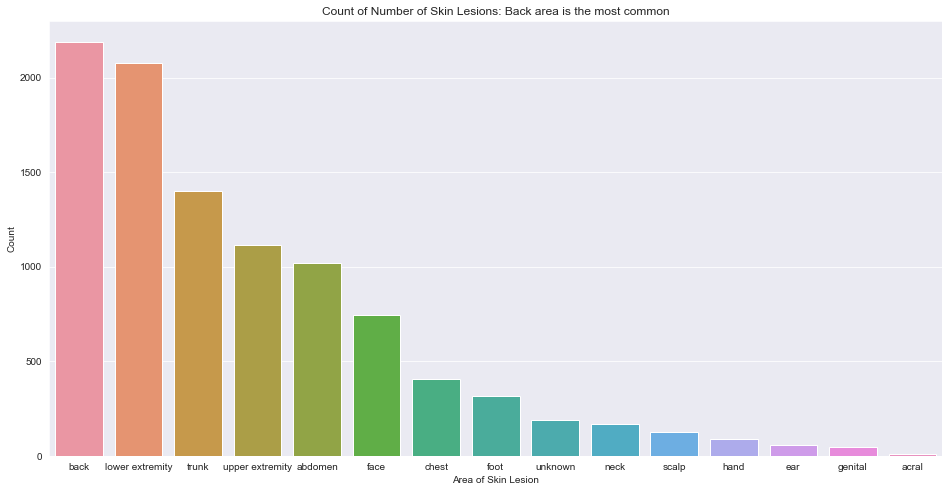

In [7]:
plt.figure(figsize=(16,8))
sns.set_style("darkgrid")

ax = sns.barplot(x = df['localization'].value_counts().index, y = df['localization'].value_counts())
ax.set_xlabel('Area of Skin Lesion')
ax.set_ylabel('Count')
ax.set_title("Count of Number of Skin Lesions: Back area is the most common")

Looking at the amount of different kinds of diagnoses

Text(0.5, 1.0, 'Count of Number of Diagnoses, nv is the most common')

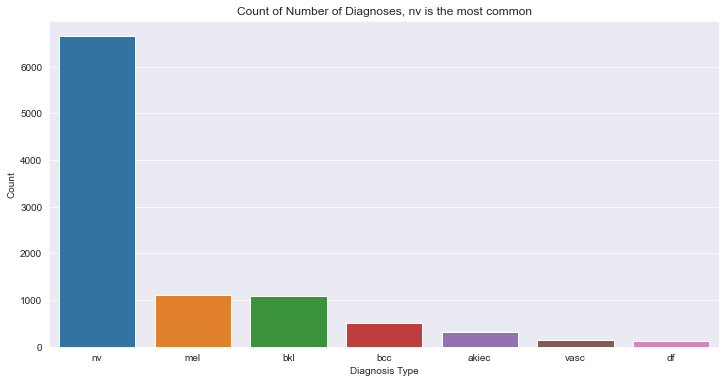

In [8]:
plt.figure(figsize=(12,6))
sns.set_style("darkgrid")

ax1 = sns.barplot(x = df['dx'].value_counts().index, y = df['dx'].value_counts())
ax1.set_xlabel('Diagnosis Type')
ax1.set_ylabel('Count')
ax1.set_title("Count of Number of Diagnoses, nv is the most common")

In [9]:
nv_percentage = 100 * len(df[df['dx'] == 'nv']) / len(df)
nv_percentage = '{0:.4g}'.format(nv_percentage) + "%"

print('dx type nv makes up', nv_percentage ,'of the database')

dx type nv makes up 66.85% of the database


From the Description of our diagnoses types, we know that these labels mean this

*   melanocytic nevi (nv)
*   melanoma (mel)
*   benign keratosis-like lesions (bkl)
*   basal cell carcinoma (bcc)
*   Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
*   vascular lesions (vasc)
*   dermatofibroma (df)

And melanocytic nevi makes up about 2/3rds of all our dx counts, so our data is largely imbalanced, but luckily we have some tools to account for problems such as imbalanced data


Taking a look at the Age distribution, 40-50 are the most commmon

Text(0, 0.5, 'Count')

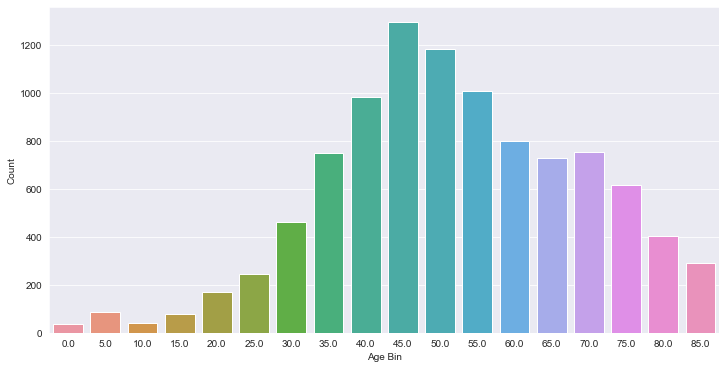

In [10]:
plt.figure(figsize=(12,6))
sns.set_style("darkgrid")

df_age = df['age'].value_counts()
df_age.index = df_age.index.astype(float)
df_age = df_age.sort_index(ascending=True)

ax2 = sns.barplot(x = df_age.index, y = df_age)
ax2.set_xlabel("Age Bin")
ax2.set_ylabel("Count")

Looking at genders to see if there's an imbalance, our data slightly skews male

In [11]:
df['sex'].value_counts()

male      5400
female    4548
Name: sex, dtype: int64

<AxesSubplot:ylabel='sex'>

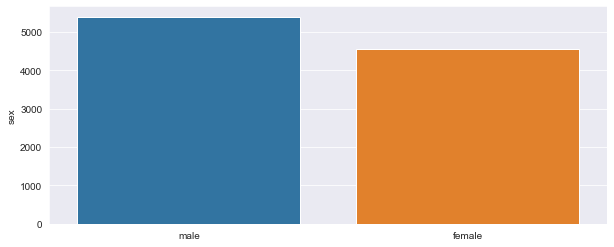

In [12]:
plt.figure(figsize=(10,4))
sns.set_style("darkgrid")

sns.barplot(x = df['sex'].value_counts().index, y= df['sex'].value_counts())


##  LEARNINGS FROM EDA
A huge problem that stands out from this data set is that there is a major imbalance in the dx columns. Melanocytic nevi accounts for the majority of values in our dx column. To account for this, we will have to use certain techniques like image generation, oversampling, and undersampling.

# CONVERTING JPG IMAGES TO RGB PIXEL DATA

We will be resizing our images to 32 x 32 images so we can fit all the pictures into our input layers of our model

In [13]:
#We want to create 32 x 32 images. So we specify an image size for the pixel width and height of our image. If you desire to
#read in the images as 28 x 28 or even higher resolution. You can change this value. However this may causes unpredictable
#changes in the training of our model
IMAGE_SIZE = 32

# This cell finds all of the jpg images in directory and creates a full path of where the image is located
image_path = {os.path.splitext(os.path.basename(x))[0]: x
               for x in glob(os.path.join('Data/', '*', '*.jpg'))}

# Creating a new column in our dataframe and our dictionary to set the respective file paths to each corresponding image_id
df['image_path'] = df['image_id'].map(image_path.get)

# We create a lambda function to open each image file in our 'image_path' column and conver them to 32 x 32 x 3 Numpy Arrays
df['image_data'] = df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((IMAGE_SIZE,IMAGE_SIZE))))

Comparing Original Image to Pixel Image

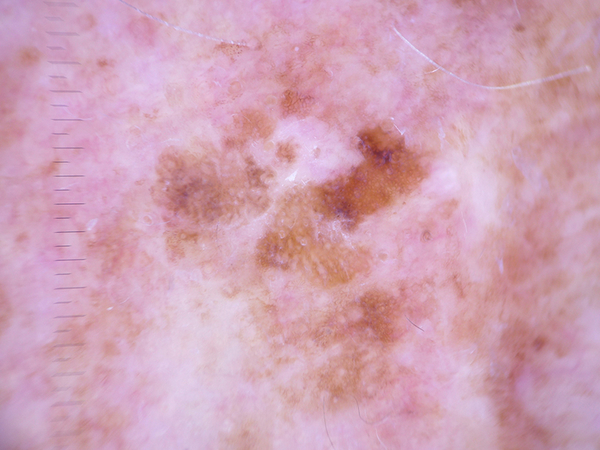

In [14]:
#Original 600 x 450 pixel image
PIL.Image.open(df['image_path'].iloc[0])

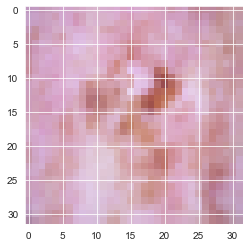

In [15]:
# Image Pixel Data mapped out into a 32 x 32 rgb image

plt.imshow(df['image_data'].iloc[0].reshape(32,32,3))
plt.show()

# NORMALIZING PIXEL DATA AND ONE-HOT-ENCODING TARGET DATA

In [16]:
#Divide our RGB values by 255, now they take on values from [0,1]. This helps with the training of the model

#Convert to list to allow list division
X = np.asarray(df['image_data'].tolist())

X = X / 255.

# One-Hot-Encoding our Labels
Y = df['dx_encodings']
Y = tf.keras.utils.to_categorical(Y, num_classes=7)

# BALANCING OUR DATA

In [17]:
#Our one-hot encoded labels
pd.DataFrame(Y).value_counts()

0    1    2    3    4    5    6  
0.0  0.0  0.0  0.0  0.0  1.0  0.0    6650
                    1.0  0.0  0.0    1111
          1.0  0.0  0.0  0.0  0.0    1089
     1.0  0.0  0.0  0.0  0.0  0.0     514
1.0  0.0  0.0  0.0  0.0  0.0  0.0     327
0.0  0.0  0.0  0.0  0.0  0.0  1.0     142
               1.0  0.0  0.0  0.0     115
dtype: int64

Using Random Under Sampler, it will undersample from dx types such as 'nv' and oversample other minority 'dx' classes.

Through testing different values of Undersampling, we settled on 3000 to be our bound for UnderSampling. This makes it so that the accuracy of the majority class of melanocytic nevi would not be impacted too much in testing.

In [18]:
sampling_strategy = {5: 3000}
#Preserve the shape of the input
num_samples, dim_x, dim_y, dim_z = X.shape
#Flatten the data so that it can sampled
X = X.reshape((num_samples,dim_x*dim_y*dim_z))

random_undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy)

X, y = random_undersampler.fit_resample(X, Y)
#Reshape to previous dimensions
X = X.reshape((len(X),dim_x,dim_y,dim_z))

We then utilize the Random Over Sampler, to match the number of samples from our minority classes to match the number of samples as our melanocytic nevi

In [19]:
#Preserve the shape of the input
num_samples, dim_x, dim_y, dim_z = X.shape

#Flatten the data so that it can sampled
X = X.reshape((num_samples,dim_x*dim_y*dim_z))

random_oversampler = RandomOverSampler()

X, y = random_oversampler.fit_resample(X, y)
#Reshape to previous dimensions
X = X.reshape((len(X),dim_x,dim_y,dim_z))

Our classes are now balanced

<AxesSubplot:xlabel='0,1,2,3,4,5,6'>

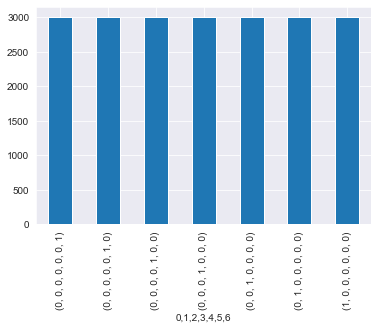

In [20]:
pd.DataFrame(y).value_counts().plot(kind='bar')

# TRAINING AND TESTING THE MODEL

Split the Data into 70:30 Training and Testing

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= .3, random_state = 32)

Convolutional Neural Networks are not Scale or Rotation Invariant, to account for this, we use Data Augmentation to prevent overfitting

In [22]:
#We augment the images through the various parameters. From the name of the parameters, they are quite self explanatory
Image_Data_Generator = ImageDataGenerator(height_shift_range = .15,
                                          width_shift_range = .15, 
                                          horizontal_flip = True,
                                          vertical_flip = True,
                                          rotation_range = 30,
                                          zoom_range = .1)

Image_Data_Generator.fit(X_train)

In [23]:
#Final sizes of Train and Test Dataset

print("X_train:", len(X_train),", y_train: ", len(y_train),", X_test: ", len(X_test),", y_test:", len(y_test))

X_train: 14700 , y_train:  14700 , X_test:  6300 , y_test: 6300


In [33]:
#Specifying the image shape for our input convolutional layer
input_shape = (IMAGE_SIZE, IMAGE_SIZE , 3)

model = Sequential([
    #Input Layer
    #Each layer composes of two convolutional layers, with a Max-pooling layer, then with a BatchNormalization Layer
    #To normalize the outputs
    Conv2D(64, kernel_size = (3, 3), padding ='same',activation="relu", input_shape=input_shape),
    Conv2D(64, kernel_size = (3, 3), padding ='same',activation="relu"),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(128, kernel_size = (3, 3), padding ='same',activation="relu"),
    Conv2D(128, kernel_size = (3, 3), padding ='same',activation="relu"),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(256, kernel_size = (3, 3),padding ='same',activation='relu'),
    Conv2D(256, kernel_size = (3, 3),padding ='same',activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(64, kernel_size = (3, 3),padding ='same',activation='relu'),
    Conv2D(64, kernel_size = (3, 3),padding ='same',activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    #Flatten before connecting to fully-dense layers
    Flatten(),
    Dropout(.25),
    Dense(128, activation = 'relu'),
    Dense(64, activation ='relu'),
    #We use softmax as our activation function for the output layer
    Dense(7,activation = 'softmax')
])

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)        

In [34]:
#callback function to stop the model training to prevent the model from overfitting
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose = 1, mode= "auto")

#This callback makes it so that the best weights will be saved
callback_model_checkpoint = ModelCheckpoint("best_model_weights.hdf5", save_best_only=True,
                                                               monitor='val_loss', mode = "min")

batch_size = 64 
epochs = 50

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_test, y_test),
    verbose=2, callbacks = [callback_early_stopping, callback_model_checkpoint])

Epoch 1/50
230/230 - 72s - loss: 1.3041 - acc: 0.4975 - val_loss: 2.4566 - val_acc: 0.2316
Epoch 2/50
230/230 - 70s - loss: 0.7883 - acc: 0.7042 - val_loss: 1.2671 - val_acc: 0.5313
Epoch 3/50
230/230 - 71s - loss: 0.5749 - acc: 0.7846 - val_loss: 0.9371 - val_acc: 0.6635
Epoch 4/50
230/230 - 73s - loss: 0.4356 - acc: 0.8376 - val_loss: 0.9309 - val_acc: 0.6700
Epoch 5/50
230/230 - 71s - loss: 0.3578 - acc: 0.8643 - val_loss: 0.5468 - val_acc: 0.7894
Epoch 6/50
230/230 - 71s - loss: 0.2730 - acc: 0.8982 - val_loss: 0.8608 - val_acc: 0.7140
Epoch 7/50
230/230 - 72s - loss: 0.2378 - acc: 0.9120 - val_loss: 0.9082 - val_acc: 0.7063
Epoch 8/50
230/230 - 72s - loss: 0.1878 - acc: 0.9295 - val_loss: 1.1263 - val_acc: 0.7206
Epoch 9/50
230/230 - 72s - loss: 0.1876 - acc: 0.9299 - val_loss: 0.9912 - val_acc: 0.7156
Epoch 10/50
230/230 - 73s - loss: 0.1390 - acc: 0.9503 - val_loss: 0.4498 - val_acc: 0.8576
Epoch 11/50
230/230 - 69s - loss: 0.1164 - acc: 0.9573 - val_loss: 1.0550 - val_acc: 0.71

Run the cell below to load in the model that has been previously trained

In [26]:
#model = keras.models.load_model('CNN_skin_lesion_model')

This cell does a direct comparison with the testing ground truth data and the model's predictions. 

In [35]:
score = model.evaluate(X_test, y_test)
print('Testing Accuracy:', score[1])

197/197 [==============================] - 7s 35ms/step - loss: 0.2427 - acc: 0.9381
Testing Accuracy: 0.938095211982727


We can see that the Testing Accuracy 

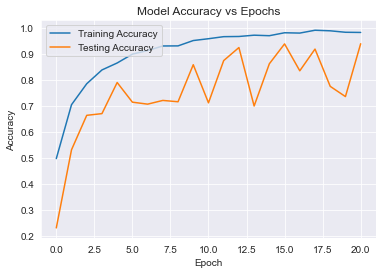

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper left')

plt.show()

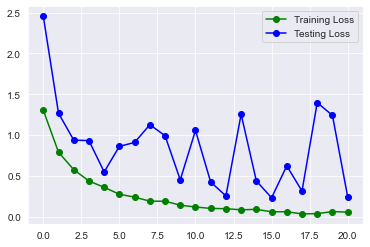

In [37]:
plt.plot(history.history["loss"] , 'go-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'bo-' , label = "Testing Loss")
plt.legend()

plt.show()

Run this cell below to save the model

In [30]:
#model.save('CNN_skin_lesion_model')

This is the confusion matrix for our model. Any values that lie outside of the diagonal are the misdiagnosed classes.

<AxesSubplot:>

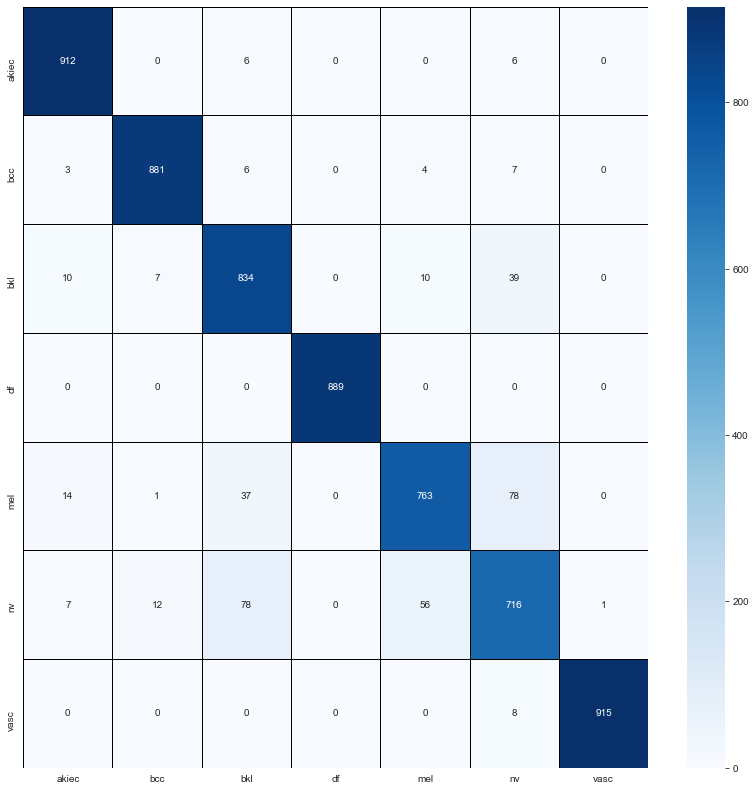

In [38]:
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))

conf_matrix = pd.DataFrame(conf_matrix , index = ['akiec','bcc', 'bkl', 'df','mel' ,'nv', 'vasc'],
                  columns = ['akiec','bcc', 'bkl', 'df','mel' ,'nv', 'vasc'])

plt.figure(figsize = (14,14))
sns.heatmap(conf_matrix,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')